In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import words
from gensim.models import KeyedVectors
import gensim.downloader as api
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import os

from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt


In [3]:
# this function will find dictionary words in the input string
def find_words(subs):
    
    i = 0
    j = 4
    w = set()
    for s in subs:
        if len(s) < 4:
            continue
        for i in range(len(s) - 1):
            for j in range(3, len(s) - i):
                #print(s[i:i+j+1], s[i:i+j+1] in d)
                if s[i:i+j+1] in d:
                    w.add(s[i:i+j+1])
    return w

In [4]:
df = pd.read_csv('urlset/urlset.csv', error_bad_lines=False, encoding='latin1')
urls = df['domain'].to_numpy()
labels = df['label'].to_numpy()

d = set(words.words())
word_vectors = api.load("glove-wiki-gigaword-100")  

print('data loaded')

<ipython-input-4-09b475e720f2>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('urlset/urlset.csv', error_bad_lines=False, encoding='latin1')
b'Skipping line 18259: expected 14 fields, saw 15\nSkipping line 18273: expected 14 fields, saw 15\n'
<ipython-input-4-09b475e720f2>:1: DtypeWarning: Columns (1,2,3,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('urlset/urlset.csv', error_bad_lines=False, encoding='latin1')


data loaded


(9999, 1)


In [5]:
#Preprocess & randomize data, this is so we avoid the first n urls all being labelled 1
urls_short = []
labels_short = []
for u in range(len(urls)):
    n = np.random.rand()
    if n < 0.05:
        urls_short.append(urls[u])
        labels_short.append(labels[u])
    
label_dict= {}
for i in range(len(urls_short)):
    label_dict[urls_short[i]] = labels_short[i]


In [24]:

#we will label nodes with their index in this list rather than the word itself

#set of all urls and similar words
all_nodes = set()
    
#dict of url to similar words
all_edges = {}


for i in range(len(urls_short)):
    url = str(urls_short[i])
    
    #finds the related words
    sub_domains = url.split('/')[1:]
    w = find_words(sub_domains)
    
    all_edges[url] = set(w)
    all_nodes.add(url)
    
    #will go through and find the similar words for each word in w
    for j in w:
        j = str(j)
        try:
            similar = set((np.asarray(word_vectors.most_similar([j], topn=10, restrict_vocab=None)).T)[0])
        except:
            #set it up as an empty set if there are no similar words
            similar = set()
            
        
        # add to similar words for graph creation 
        all_edges[j] = similar
        
        #adds the word from w to the listo of nodes
        if j not in all_nodes:
            all_nodes.add(j)
    
            
        #adds nodes and edges for the similar words, attaches similar words to the initial word in the subdirectory
        #NOT to the url itself.
        for k in similar:
            k = str(k)
            if k not in all_nodes:
                all_nodes.add(k)
    

In [19]:
node_index = {}
index_node = {}
label_index = {}
i = 0
for n in all_nodes:
    node_index[n] = i
    index_node[i] = n
    if (n in label_dict) and (not np.isnan(label_dict[n])):
        label_index[i] = int(label_dict[n])
    else:
        label_index[i] = 0
    i+=1
    


In [9]:
Gnx = nx.Graph()
for node in all_edges:
    if node not in Gnx:
        Gnx.add_node(node_index[node])
for node in all_edges:
    for edge in all_edges[node]:
        if not Gnx.has_edge(node_index[node], node_index[edge]):
            Gnx.add_edge(node_index[node], node_index[edge])

In [10]:
nx.write_adjlist(Gnx, 'graph_adjlist.txt')

In [11]:
# Defining Metric for Phishing Likelihood

# Each word node will get a score, counting all the phishing urls that have an edge to that word
# Each url will then be scored on the sum of the words it connects to

node_counts = {}
best_word = ''
bwc = 0
for i in range(len(urls_short)):
    url = urls_short[i]
    for url_word in Gnx.neighbors(node_index[url]):
        if labels_short[i]:   
            if url_word not in node_counts:
                node_counts[url_word] = 1
            else:
                node_counts[url_word] += 1
        else:
            if url_word not in node_counts:
                node_counts[url_word] = 0
            
        for sim_word in Gnx.neighbors(url_word):
            if labels_short[i]:   
                if sim_word not in node_counts:
                    node_counts[sim_word] = 1
                else:
                    node_counts[sim_word] += 1
            else:
                if sim_word not in node_counts:
                    node_counts[sim_word] = 0
      

In [21]:
phishing = {}
safe = {}

for i in range(len(urls_short)):
    sum_phishing = 0
    url = urls_short[i]
    for url_word in Gnx.neighbors(node_index[url]):
        sum_phishing += node_counts[url_word]
        for sim_word in Gnx.neighbors(url_word):
            sum_phishing += node_counts[sim_word]
    if labels_short[i]:
        phishing[url] = sum_phishing
        node_counts[url] = sum_phishing
    else:
        safe[url] = sum_phishing
        node_counts[url] = sum_phishing
            
print('Phishing Average: %.2f' % (sum(phishing.values())/len(phishing.values())))
print('Safe Average: %.2f' % (sum(safe.values())/len(safe.values())))
print(len(phishing.values()))
            

Phishing Average: 828281.35
Safe Average: 158379.46
2300


(40000,)
(40000,)


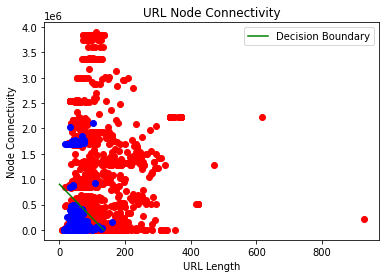

In [13]:
px = []
py = []
sx = []
sy = []

for ph in phishing:
    py.append(int(phishing[ph]))
    px.append(len(ph))
    
for sf in safe:
    sy.append(int(safe[sf]))
    sx.append(len(sf)) 

dby = np.linspace(0,900000,40000)
print(dby.shape)
dbx = (dby-900000)*(-180/1200000)
print(dbx.shape)
plt.plot(px, py, 'ro')
plt.plot(sx,sy, 'bo')
plt.plot(dbx,dby, 'g-', label='Decision Boundary')
plt.xlabel('URL Length')
plt.ylabel('Node Connectivity')
plt.title('URL Node Connectivity')
plt.legend(loc="upper right")
plt.show()

In [17]:
acc = []
acc_phishing = []
acc_safe = []
for i in range(len(urls_short)):
    url = urls_short[i]
    if all_counts[node_index[url]] > (-1200000/150)*len(url)+300000:
        if labels_short[i]:
            acc.append(1)
            acc_phishing.append(1)
        else:
            acc.append(0)
            acc_safe.append(0)
    else:
        if labels_short[i]:
            acc.append(0)
            acc_phishing.append(0)
        else:
            acc.append(1)
            acc_safe.append(1)
    
print(sum(acc)/len(acc))
print(sum(acc_phishing)/len(acc_phishing))
print(sum(acc_safe)/len(acc_safe))

0.6840203994900127
0.83
0.544472152950956


In [28]:
print(node_counts)

{3226: 106, 8984: 176, 919: 106, 8577: 95, 2314: 103, 3333: 113, 13999: 117, 7320: 1574, 8810: 1126, 2800: 246, 13468: 1883, 4258: 428, 16101: 176, 247: 1064, 13576: 176, 8771: 1124, 5037: 1291, 800: 1036, 7145: 778, 7525: 913, 13012: 820, 11370: 1217, 15029: 830, 12712: 103, 13493: 323, 1268: 324, 392: 323, 46: 323, 4841: 428, 6310: 428, 9676: 797, 16872: 472, 368: 572, 9099: 287, 4027: 112, 9689: 1198, 3475: 176, 5426: 176, 11461: 1391, 4065: 246, 5668: 369, 6193: 929, 5549: 572, 15530: 1239, 2980: 98, 13827: 1015, 9107: 572, 223: 1015, 7157: 885, 3537: 246, 16470: 176, 11719: 1136, 7884: 241, 171: 176, 10507: 665, 11292: 660, 3550: 278, 12860: 1727, 13393: 797, 4846: 428, 12104: 428, 13785: 965, 966: 428, 13698: 2267, 16477: 1307, 15931: 1400, 3552: 998, 7114: 1400, 1790: 535, 254: 176, 8825: 814, 16028: 1282, 16161: 1015, 13246: 435, 13307: 320, 6213: 209, 782: 176, 12478: 357, 5727: 970, 3039: 433, 16627: 210, 11779: 1400, 13298: 632, 4608: 176, 3127: 176, 2415: 709, 4083: 176, 59

In [30]:
# Create new graph where the only nodes are URLs, and edges are made 
# between any two urls that have paths to eachother. The edge weights 
# will be the sum of all node values previously defined along paths

G = nx.Graph()
cxn_levels = {}
t = 1

for i in range(len(urls_short)-1):
    for j in range(i+1, len(urls_short)):
        if i*j > (len(urls_short)**2)/(10/t):
            print(f'{t*10}%', end= ' ')
            t+=1
        
        url1 = urls_short[i]
        url2 = urls_short[j]
        
        if url1 == url2:
            continue
        
        if node_index[url1] not in G:
            G.add_node(node_index[url1])
        if node_index[url2] not in G:
            G.add_node(node_index[url2])

        if len(all_edges[url1].intersection(all_edges[url2])) > 1:
            G.add_edge(node_index[url1], node_index[url2], weight = len(all_edges[url1].intersection(all_edges[url2]))/10)


10% 20% 30% 40% 50% 60% 70% 80% 90% 0


In [ ]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy
from sklearn import svm

pxy = np.asarray([px,py]).T
sxy = np.asarray([sx,sy]).T

X = np.concatenate((pxy,sxy), axis = 0)
Y = np.array([0]*len(px) + [1]*len(sx))

C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel = 'rbf',  gamma=0.7, C=C )
clf.fit(X, Y)

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

In [32]:
sim_words = set()
for n in all_edges:
    for w in all_edges[n]:
        sim_words.add(w)
        
sim_word_vecs = {}
for n in G.nodes:
    l = []
    for w in sim_words:
        if w in all_edges[n]:
            l.append(1)
        else:
            l.append(0)
    sim_word_vecs[n] = l

KeyError: 8984

In [106]:
fs = []
nodes = []

for n in G.nodes:
    nodes.append(n)
    fs.append(sim_word_vecs[n])

features = pd.DataFrame(fs, index=nodes)
G = StellarGraph.from_networkx(Gnx, node_features = features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 26646, Edges: 51143

 Node types:
  default: [26646]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [51143]
        Weights: all 1 (default)
        Features: none


In [107]:
url_set = pd.Series(label_index)
train_nodes, test_nodes = model_selection.train_test_split(url_set, train_size=5000, test_size=None, stratify=url_set)
val_nodes, test_nodes = model_selection.train_test_split(test_nodes, train_size=10000, test_size=None, stratify=test_nodes)

In [108]:
train_nodes.value_counts().to_frame()

,0
0,4100
1,900


In [109]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [110]:
train_gen = generator.flow(train_nodes.index, train_nodes)

In [111]:
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)

In [112]:
x_inp, x_out = gcn.in_out_tensors()

In [113]:
predictions = layers.Dense(units=1, activation="softmax")(x_out)

In [114]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=10),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

val_gen = generator.flow(val_nodes.index, val_nodes)
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [115]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 1s - loss: 7665.4756 - acc: 0.1800 - val_loss: 16587.8242 - val_acc: 0.1801 - 947ms/epoch - 947ms/step
Epoch 2/200
1/1 - 0s - loss: 7665.4756 - acc: 0.1800 - val_loss: 16587.8242 - val_acc: 0.1801 - 63ms/epoch - 63ms/step
Epoch 3/200
1/1 - 0s - loss: 7665.4756 - acc: 0.1800 - val_loss: 16587.8242 - val_acc: 0.1801 - 63ms/epoch - 63ms/step
Epoch 4/200
1/1 - 0s - loss: 7665.4756 - acc: 0.1800 - val_loss: 16587.8242 - val_acc: 0.1801 - 59ms/epoch - 59ms/step
Epoch 5/200
1/1 - 0s - loss: 7665.4756 - acc: 0.1800 - val_loss: 16587.8242 - val_acc: 0.1801 - 67ms/epoch - 67ms/step
Epoch 6/200
1/1 - 0s - loss: 7665.4756 - acc: 0.1800 - val_loss: 16587.8242 - val_acc: 0.1801 - 62ms/epoch - 62ms/step
Epoch 7/200
1/1 - 0s - loss: 7665.4756 - acc: 0.1800 - val_loss: 16587.8242 - val_acc: 0.1801 - 63ms/epoch - 63ms/step
Epoch 8/200
1/1 - 0s - loss: 7665.4756 - acc: 0.1800 - val_loss: 16587.8242 - val_acc: 0.1801 - 61ms/epoch - 61ms/step
Epoch 9/200
1/1 - 0s - loss: 7665.4756 - acc: 